# peaks Tutorial 1: Getting started

`peaks`: Python Electron spepctroscopy and diffraction Analysis by King group St Andrews.

`peaks` is a collection of analysis tools for the loading, processing and display of spectroscopic and diffraction data, with a core focus on tools for angle-resolved photoemission, electron energy loss spectroscopy, LEED, RHEED, and some other related techniques. It also includes various functions for efficient log keeping and experimental system monitoring.

This tutorial gives a brief getting started guide, including on loading and visualising data.

## Importing peaks
If you are running with `peaks` stored in a local folder, first add the folder path to `sys` with the following (if `peaks` is installed as described in the installation guide, this step is not needed):
```
import sys
sys.path.insert(0, '../')  # Provide here relative path from notebook to the root folder of peaks
```

Now import peaks. A core set of functions can be loaded directly into the namespace using
```
from peaks.core import *
```

In [3]:
##### These lines just for debugging purposes #####
%load_ext autoreload
%autoreload 2
%aimport peaks
####################################################

from peaks.core import *

## Loading data
The core function for loading data is `load_data`

In [4]:
help(load_data)

Help on function load_data in module peaks.core.fileIO.data_loading:

load_data(fname, loc=None, extension=None, sum_scans=False, merge_scans=False, merge_kwargs=None, sum_sweeps=True, binning=None, name=None, chunks='auto', persist=True, parallel=None, Artemis_kw=None, **slice_kwargs)
    Load data, returning an xarray with data stored in dask arrays by default.
    
    Parameters
    ----------
    fname : str or list
        if str : Path to the file or folder to be loaded
        if list : List of strings pointing to multiple scans to load
    
    loc : str, optional
        Name of beamline or other data designator <br>
        If None supplied, will be attempted to be determined from data, but can speed up loading
        for some files if supplied <br>
        For currently supported options, see `fileIO.fileIO_opts.loc_opts`
    
    extension : str, optional
        Specify file extension (e.g. .txt) <br>
        Useful  if a folder of scans is being loaded.
    
    sum_sca

The beamline will be attempted to be determined automatically, or can be passed directly with the `loc=` keyword. Currently supported beamlines are:

In [5]:
print(fileIO_opts.loc_opts)

['ALBA LOREA', 'Artemis', 'Bruker XRD', 'Diamond I05-HR', 'Diamond I05-nano', 'Elettra APE', 'MAX IV Bloch', 'MAX IV Bloch spin', 'netCDF file', 'SOLEIL CASSIOPEE', 'St Andrews - Phoibos', 'St Andrews - MBS', 'structure', 'LEED', 'RHEED']


In [6]:
a = load_data("example_data/i05-59819.nxs")  # This is a 2D plot (dispersion)

A helper function `load` exists to simplify file loading where filename formats follow similar structures

In [7]:
help(load)

Help on function load in module peaks.core.fileIO.data_loading:

load(fname, **kwargs)
    Shortcut function to load_data with much of the file path set by global options:
        fileIO_opts.fname.path
        fileIO_opts.fname.ext - can be a list of multiple extensions
    
    Parameters
    ------------
    fname : int or str or list
        if int or str : Remainder (or start) of file name not already specified in global options
        if list : List of the above
    
    **kwargs : optional
        Additional options that can be passed to `peaks.fileIO.load_data`
    
    
    Returns
    ------------
    xr.DataArray or xr.DataSet or list(xr.DataArray) or list(xr.DataSet)
        xarray DataArray or DataSet with loaded data <br>
        Returned with arrays as dask objects or list of these
        where data is generated by load_data(fileIO_opts.fname.path + fname + fileIO_opts.fname.ext)
    
    
    Examples
    ------------
    from peaks import *
    
    # First set file 

First need to set the common file path and extensions (or list of extensions) of file names to consider

In [8]:
fileIO_opts.fname.path = 'example_data/'
fileIO_opts.fname.ext='.nxs'

In [67]:
a = load(819)  # Loads scan i05-59819.nxs is folder example_data

Can also set a default location specifying the loader to use

In [10]:
fileIO_opts.fname.loc = 'Diamond I05-HR'

In [11]:
a = load(819)  # Loads scan i05-59819.nxs is folder example_data

Can also crop on load - this is not that important for a dispersion, but can be well worth it for higher-D data (e.g. spatial maps) which can have very large file sizes, to reduce the memory cost

In [12]:
b = load(819, theta_par=slice(-15,15),eV=slice(104.6,105.3))

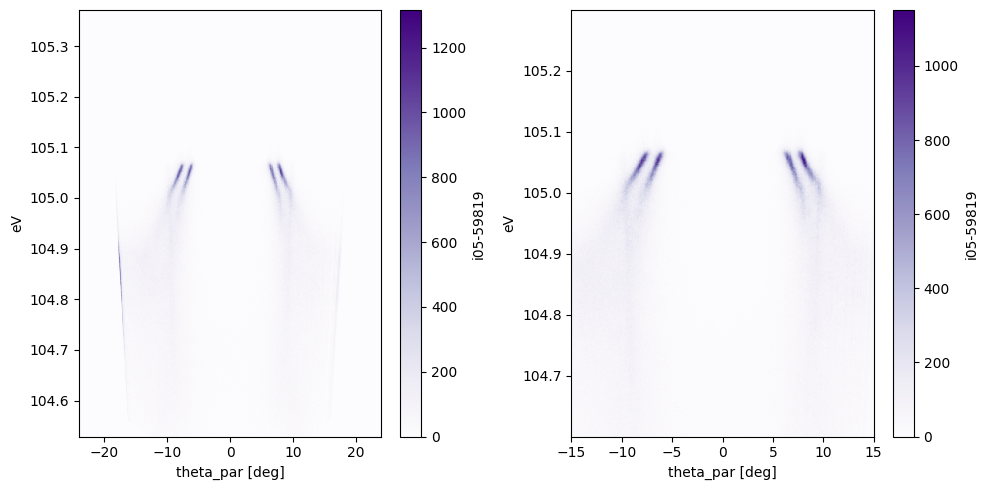

In [13]:
plot_grid([a,b])

Multiple scans can be loaded into a list by passing a list of filenames (or shortcuts if using the `load` function

In [72]:
b = load([819,818])

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
type(b)

list

In [16]:
type(b[1])

xarray.core.dataarray.DataArray

Note, if `fileIO_opts.fname.ext` is left empty, then all file extensions are allowed. A list can also be supplied for various possible extensions. If `fileIO_opts.fname.path` is left empty, assumes current directory. If not working in current directory, at a minimum, the directory should be given here. Additional partial file name strings can be used to aid disambiguation of files in directory, e.g. `fileIO_opts.fname.path = 'example_data/i05-'`

### Summing spectra
Sometimes it is desirable to add multiple scans together, e.g. when multiple scans are collected for stats. Here, simply doing a + b will fail to keep all the attributes (which are needed for various processing), and will also fail if there are small numerical noise errors on the e.g. energy or angular axes. To sum multiple scans, you can call directly the `.utils.sum_spectra.sum_spec` method with the relevant arrays passed as arguments and ussing the flag `sum_scans=True` which will by default call the `sum_spec` method on the passed data:

In [17]:
help(sum_spec)

Help on function sum_spec in module peaks.core.utils.sum_spectra:

sum_spec(*args)
    Sum two or more dataarrays together, maintaining the metadata
    
    Input:
        *args - any number of data arrays to sum together (xarray)
    
    Returns:
        data_out - a single summed dataarray



Some scans when measured using the Scienta SES software are recorded in so-called 'add dimension' mode, which each sweep is saved as a new layer in the data. By default, these are summed on load, but can be kept as seperate sweeps using the flag `sum_sweeps=False`

In [73]:
c1 = b[0].isel(polar=100)
c2 = b[0].isel(polar=101)
c = sum_spec(c1,c2)

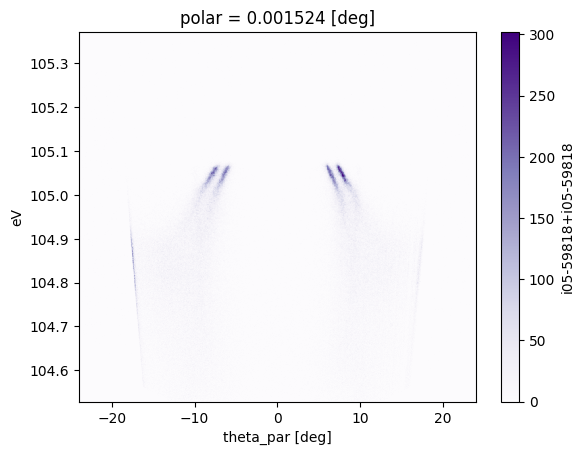

In [19]:
c.plot()

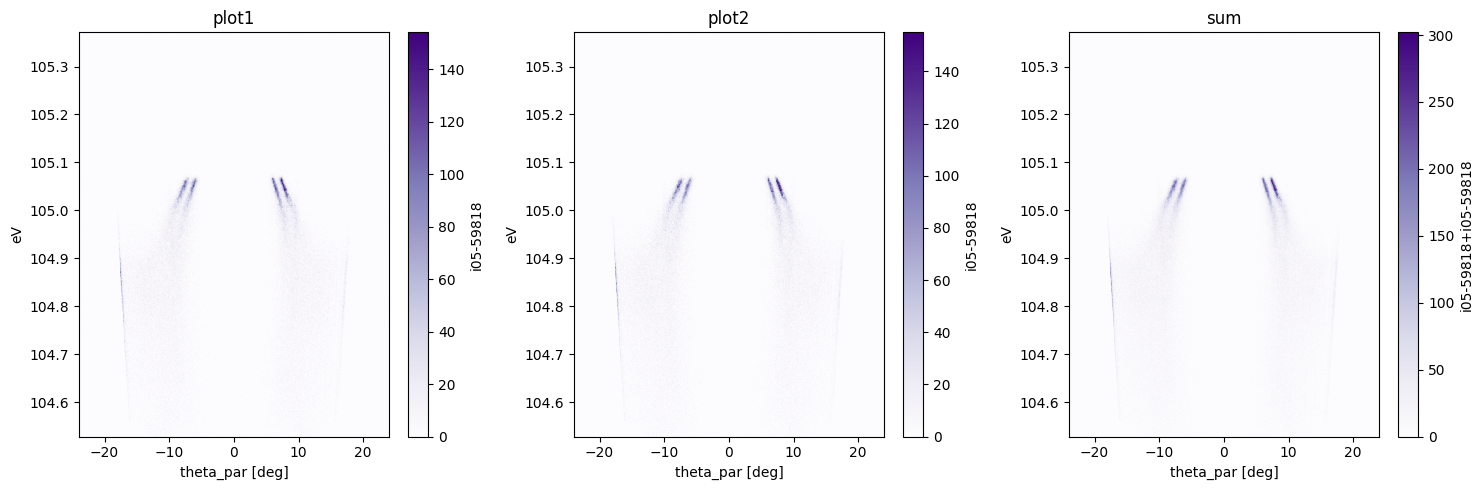

In [20]:
plot_grid([c1,c2,c],titles=['plot1','plot2','sum'])

### Load metadata from the logbook

To load metadata from a logbook into the xarray attributes, use `load_metadata`

In [21]:
help(load_metadata)

Help on function load_metadata in module peaks.core.fileIO.metadata_loading:

load_metadata(*args, **kwargs)
    This function retrieves the metadata saved in a spreadsheet for the input scans, converts it to peaks conventions and updates the input xarrays attrs accordingly
    
    Input:
        *args:
            data for which metadata will be loaded from the logbook (DataArray, DataSet, or list of DataArrays and/or DataSets)
        **kwargs:
            sample_name - the name of the sample (string)
            spreadsheet identifier (one of the following):
                key_ID - Key ID of the project spreadsheet (string)
                project_name - name of the project (string)
                proposal_ID - beamtime proposal ID (string)



In [22]:
al = load_data('example_data/210326_GM2-667_GK_1.xy')
al.attrs

{'scan_name': '210326_GM2-667_GK_1',
 'scan_type': 'dispersion',
 'sample_description': None,
 'eV_type': 'kinetic',
 'beamline': 'St Andrews - Phoibos',
 'analysis_history': [],
 'EF_correction': None,
 'PE': 20.0,
 'hv': 21.2182,
 'pol': None,
 'sweeps': 1,
 'dwell': 2.0,
 'ana_mode': 'WideAngleMode:400V',
 'ana_slit': '5:0.7x30\\C:open',
 'ana_slit_angle': 0,
 'exit_slit': None,
 'x1': None,
 'x2': None,
 'x3': None,
 'polar': None,
 'tilt': None,
 'azi': None,
 'norm_polar': None,
 'norm_tilt': None,
 'norm_azi': None,
 'temp_sample': None,
 'temp_cryo': None}

Now load in the missing metadata from the logbook

In [23]:
al.load_metadata(sample_name='GM2-667', key_ID='13MCnfz7nDWgOk0iKTPJI_cqYqlISG3xvv-pNVtvt5hQ')
al.attrs

{'scan_name': '210326_GM2-667_GK_1',
 'scan_type': 'dispersion',
 'sample_description': 'VSe2 on HOPG',
 'eV_type': 'kinetic',
 'beamline': 'St Andrews - Phoibos',
 'analysis_history': [],
 'EF_correction': None,
 'PE': 20.0,
 'hv': 21.2182,
 'pol': None,
 'sweeps': 1.0,
 'dwell': 2.0,
 'ana_mode': 'WideAngleMode:400V',
 'ana_slit': '5:0.7x30\\C:open',
 'ana_slit_angle': 0.0,
 'exit_slit': None,
 'x1': 6.0665,
 'x2': 399.6031,
 'x3': 10.8945,
 'polar': 2.5,
 'tilt': 4.5,
 'azi': 0.0,
 'norm_polar': None,
 'norm_tilt': None,
 'norm_azi': None,
 'temp_sample': 'RT',
 'temp_cryo': 'RT'}

Other ways to call load_metadata:

```
load_metadata(DataArray, sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')

load_metadata(Dataset, sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')

load_metadata(DataArray, DataSet, DataArray, sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')

load_metadata([DataArray, DataArray], sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')

load_metadata([DataSet, DataArray, DataSet], sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')

load_metadata([DataSet, DataArray, DataSet], DataSet, DataArray, sample_name='LEEDTEST', key_ID='100nbOwXbW-yA5anGQedZLKORj-k6FveuNUxJOw-U5sY')
```

## Visualising data
### Data structure
Basic data structure is an xarray `xr.DataArray`, with the data normally stored as a numpy array, but sometimes as a dask array (for spatial mapping data), and with associated co-ordinates and metadata.

IMPORTANT: Use of peaks assumes a pretty in depth knowledge of xarray, and also some basic knowledge of dask. See: <a href="https://docs.xarray.dev/en/stable/">X-array docs</a>, <a href="https://www.dask.org/">Dask docs</a>

In [28]:
a

<xarray.DataArray 'i05-59819' (eV: 1040, theta_par: 1000)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 104.5 104.5 104.5 104.5 ... 105.4 105.4 105.4 105.4
Attributes: (12/30)
    scan_name:           i05-59819
    scan_type:           dispersion
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    []
    ...                  ...
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         12.0
    temp_cryo:           10.7
    scan_command:        static readout

The coordinates can be accessed:

In [29]:
a.coords

Coordinates:
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 104.5 104.5 104.5 104.5 ... 105.4 105.4 105.4 105.4

The attributes are a dictionary

In [30]:
a.attrs

{'scan_name': 'i05-59819',
 'scan_type': 'dispersion',
 'sample_description': None,
 'eV_type': 'kinetic',
 'beamline': 'Diamond I05-HR',
 'analysis_history': [],
 'EF_correction': None,
 'PE': 10.0,
 'hv': 110.0,
 'pol': 'LH',
 'sweeps': 600,
 'dwell': 1.0,
 'ana_mode': 'Ang30',
 'ana_slit': '0.2s (#500)',
 'ana_slit_angle': 90,
 'exit_slit': 10.0,
 'defl_par': None,
 'defl_perp': None,
 'x1': 1.09,
 'x2': -2.866,
 'x3': 0.278,
 'polar': 1.5,
 'tilt': 0.0,
 'azi': -12.5,
 'norm_polar': None,
 'norm_tilt': None,
 'norm_azi': None,
 'temp_sample': 12.0,
 'temp_cryo': 10.7,
 'scan_command': 'static readout'}

The raw underlying numpy array is stored in `.data`. Calling with `.data` returns the numpy or dask array. For dask-backed arrays, this allows lazy computations. To obtain the true numpy array from a dask-backed array, use `.compute()`, where any requried selections or operations can already be done on the data. Note this loads the data into memory, and so be sure sufficient memory is available.

### Plotting
On 1D or 2D data, a simple plot can be performed

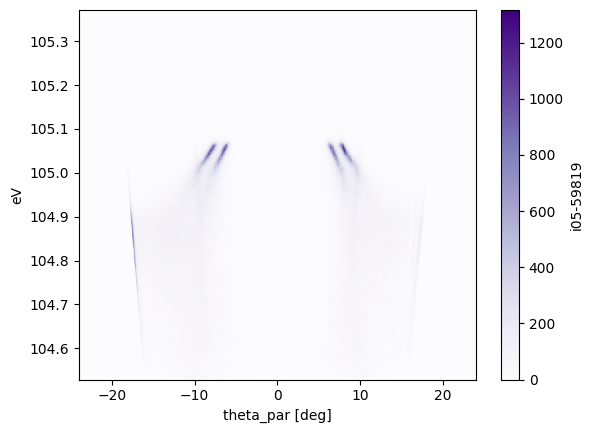

In [33]:
a.plot()

A special function `plot_grid()` exists for plotting multiple dispersions in a grid format

In [34]:
help(plot_grid)

Help on function plot_grid in module peaks.core.display.plot_2d:

plot_grid(data, ncols=3, nrows=None, titles=None, titles_col=None, sharex=False, sharey=False, **kwargs)
    Plots an array of 2D dataarrays on a grid
    
    Parameters
    ------------
    data : list(xr.DataArray)
         List containing the dispersions to be plotted
    
    ncols : int, optional
        Number of columns <br>
        Defaults to 3, or lower if <3 plots <br>
        Ignored if nrows is specified
    
    nrows : int, optional
        Number of rows <br>
        Overwrites ncols <br>
        Defaults to None (ncols used)
    
    titles : list(str)
        List of subtitles to be supplied on the plots <br>
        Length must match number of dataarrays to plot <br>
        Defaults to None
    
    titles_colors : list(str)
        List of colours for the subtitles <br>
        Length must match number of dataarrays to plot <br>
        Defaults to None
    
    sharex : bool, optional
        Share

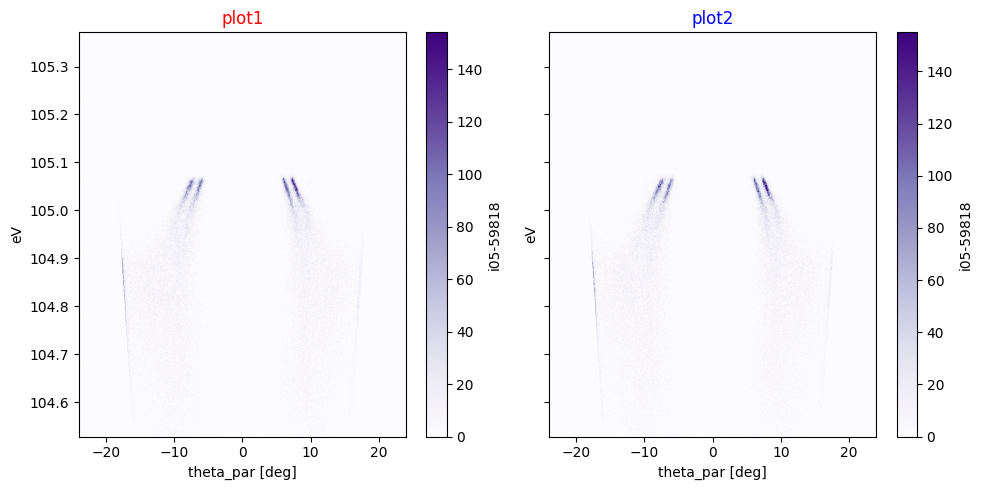

In [35]:
plot_grid([c1,c2],titles=['plot1','plot2'], titles_col=['r','b'], sharey=True)

In [65]:
type(a.data)

numpy.ndarray

### Interactive views
Interactive GUI panels exist for 2D, 3D, and 4D data sets, and can be called using `.disp()`

In [70]:
a.disp()

qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1026.45,615.13 gbl=1026.45,615.13 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1026.45,-615.13 last=-1026.45,-615.13 Δ 1026.45,615.13) : no target window


To display multiple 2D dataarrays, pass them to `disp` as a list:

In [74]:
disp([c1,c2])

qt.pointer.dispatch: skipping QEventPoint(id=0 ts=0 pos=0,0 scn=1225.81,452.267 gbl=1225.81,452.267 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1225.81,-452.267 last=-1225.81,-452.267 Δ 1225.81,452.267) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1301.95,508.966 gbl=1301.95,508.966 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1301.95,-508.966 last=-1301.95,-508.966 Δ 1301.95,508.966) : no target window


Or an inline viewer for simpler inspection

In [75]:
import matplotlib
matplotlib.use('Qt5Agg')
a.view()

A special version of the display panel exists for aiding alignment (normal emission identification) of dispersions. Call with `.align`

In [52]:
help(align)

Help on function align in module peaks.core.GUI.align.align_GUI:

align(data)
    Master load function for GUI data alignment panels. Currently works with single 2D dataarray,
    and a 3D dataarray of Fermi map data.
    
        Input:
            data - the data to align
    
        Returns:
            null - opens the relevant data alignment panel



In [81]:
a.align()

qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1225.07,606.992 gbl=1225.07,606.992 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1225.07,-606.992 last=-1225.07,-606.992 Δ 1225.07,606.992) : no target window


For 3D data (FS maps), can call with just `.disp()` for a combined viewer and alginment tool

## Selecting data
<a href="https://docs.xarray.dev/en/stable/user-guide/indexing.html">Standard xarray calls</a> can be used for indexing and selecting from the array

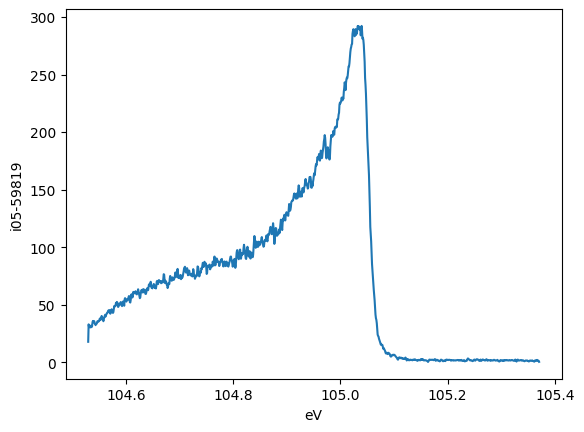

In [39]:
a.sel(theta_par=slice(-10,-8)).mean('theta_par').plot()

### DC extraction

The module `.display.DC_extract` contains some shortcut functions for rapid extraction of single or multiple MDCs and EDCs, including some plotting functions for e.g. waterfall plots.

#### Single MDC or EDC extraction

In [40]:
help(MDC)

Help on function MDC in module peaks.core.display.DC_select:

MDC(dispersion, E0, dE=0.0)
    Extract a single MDC from a dataarray
    
    Parameters
    ------------
    dispersion : xr.DataArray
         The dispersion (2D dataarray) to extract MDC from
    
    E0 : float
        Energy of MDC to extract
    
    dE : float, optional
        Integration range (total range, integrates +/- dE/2) <br>
        Defaults to single DC
    
    Returns
    ------------
    MDC : xr.DataArray
        xarray DataArray of MDC



Extract a single MDC

In [41]:
b = a.MDC(105.05)
b

<xarray.DataArray 'i05-59819' (theta_par: 1000)>
array([1.000e+01, 9.000e+00, 9.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 2.000e+00, 6.000e+00, 8.000e+00, 7.000e+00,
       3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
       6.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
       2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 5.000e+00,
       4.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 6.000e+00, 6.000e+00,
       5.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
       3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.300e+01, 2.100e+01,
...
       2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
       0.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
       2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 3.000e+00,
       2.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       3.000e+00, 4.000e+00, 6.000e+00, 1.000e+01, 6.000e+00, 2.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 6.000e+00, 1.100e+01,
       1.200e+01, 1.000e+01, 5.000e+00, 2.000e+00, 2.000e+00, 6.000e+00,
       6.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 5.000e+00,
       3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
       2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 3.000e+00, 4.000e+00, 3.000e+00], dtype=float32)
Coordinates:
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
    eV         float64 105.1
Attributes: (12/30)
    scan_name:           i05-59819
    scan_type:           dispersion
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    ['MDC extracted, integration window: 0.0']
    ...                  ...
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         12.0
    temp_cryo:           10.7
    scan_command:        static readout

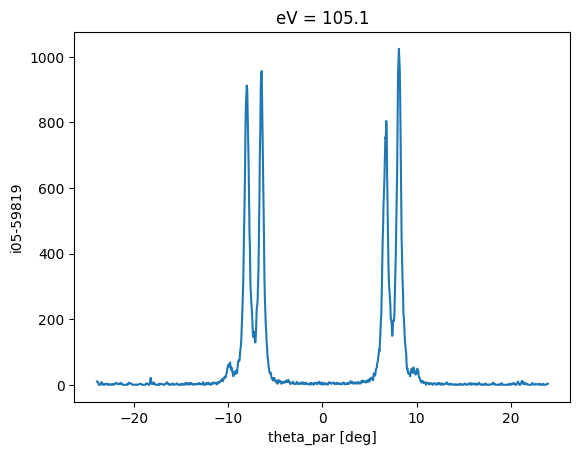

In [42]:
b.plot()

And with some integration

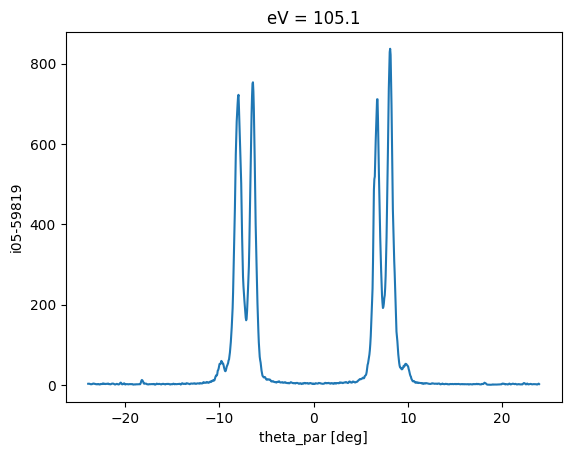

In [43]:
a.MDC(105.05, 0.02).plot()

#### Multi-DC extraction and stack plots
Can also return a stack of MDCs using the `.MDCs` function, optionally returning either an array or a plot

In [44]:
help(MDCs)

Help on function MDCs in module peaks.core.display.DC_select:

MDCs(dispersion, E0, E1, Estep, dE=0, plot=False, **kwargs)
    Extract a stack of MDCs from a dataarray, and return this or optionally return a (stack) plot
    
    Parameters
    ------------
    dispersion : xr.DataArray
         The dispersion (2D dataarray) to extract MDC from
    
    E0 : float
        Energy of first MDC to extract
    
    E1 : float
        Energy of last MDC to extract
    
    Estep : float
        Energy step between extracted MDCs
    
    dE : float, optional
        Integration range (total range, integrates +/- dE/2) <br>
        Defaults to single DC
    
    plot : bool, optional
         Call with 'plot=True' to return a plot
    
    **kwargs : optional
        Additional arguments to pass to the plotting function <br>
        Offset to define offset between DCs, plus standard matplotlib calls
    
    Returns
    ------------
    MDCs : xr.DataArray
        xarray DataArray of MDC sta

In [45]:
a.MDCs(104.9, 105.1, 0.005)

<xarray.DataArray 'i05-59819' (eV: 41, theta_par: 1000)>
array([[6., 3., 2., ..., 0., 0., 0.],
       [3., 3., 1., ..., 1., 3., 4.],
       [0., 0., 1., ..., 1., 2., 5.],
       ...,
       [3., 3., 7., ..., 4., 2., 1.],
       [0., 1., 2., ..., 0., 1., 6.],
       [0., 1., 1., ..., 4., 3., 2.]], dtype=float32)
Coordinates:
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 104.9 104.9 104.9 104.9 ... 105.1 105.1 105.1 105.1
Attributes: (12/30)
    scan_name:           i05-59819
    scan_type:           dispersion
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    ['MDCs extracted, integration window: 0']
    ...                  ...
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         12.0
    temp_cryo:           10.7
    scan_command:        static readout

This can be plotted in a stack plot using the `.plot_DCs` method:

In [46]:
help(plot_DCs)

Help on function plot_DCs in module peaks.core.display.DC_select:

plot_DCs(DCs, titles=None, cmap=None, color='k', offset=None, norm=False, stack_dim='auto', figsize=(6, 6), **kwargs)
    Plot a DC stack with the colours varying according to a colormap
    
    Parameters
    ------------
    DCs : xr.DataArray or list(xr.DataArray)
         DCs to plot, either as a list of single DC xr.DataArrays <br>
         or a single xr.DataArray with the stack of DCs included
    
    titles : list, optional
        list of subtitles to be supplied on the plots (length must match number of DCs to plot) <br>
        Defaults to None
    
    color : str, optional
        Matplotlib color, to use single color for all lines <br>
        Defaults to 'k' (black)
    
    cmap : str, optional
        name of matplotlib cmap to use <br>
        Takes presedence over color
    
    offset : float, optional
        Vertical offsets between subsequent DCs <br>
        Defaults to 5% of max peak height
  

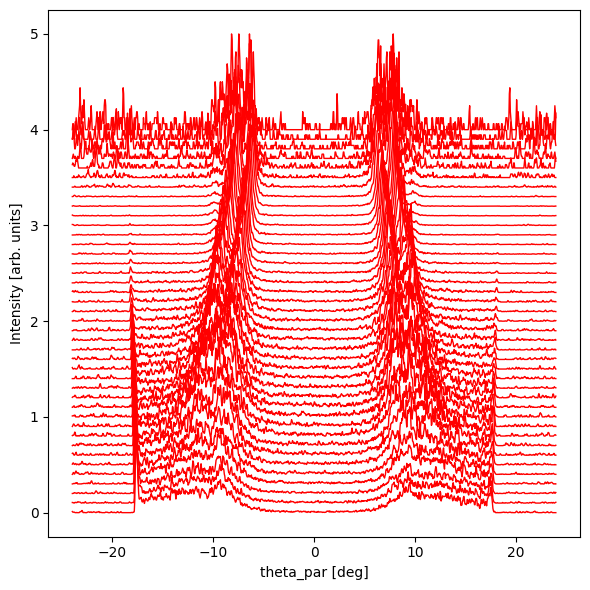

In [47]:
a.MDCs(104.9, 105.1, 0.005).plot_DCs(offset=0.1, color='r', norm=True)

Additionally, a list of single DCs can be passed to the plot_DCs function to generate a plot, with e.g. automatic color mapping etc.

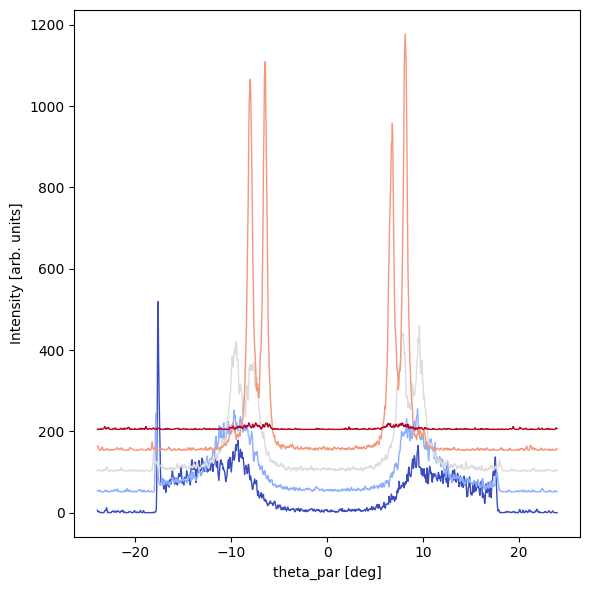

In [48]:
# Make a list of single MDCs
a_MDCs = []
for i in range(5):
    a_MDCs.append(a.MDCs(104.9, 105.1, 0.005).isel(eV=i*10))

plot_DCs(a_MDCs, cmap='coolwarm')

Alternatively, a plot can be generated automatically by calling the `.MDCs` function with the `plot=True` flag. All options for `plot_DCs` can also be passed to `.MDCs`:

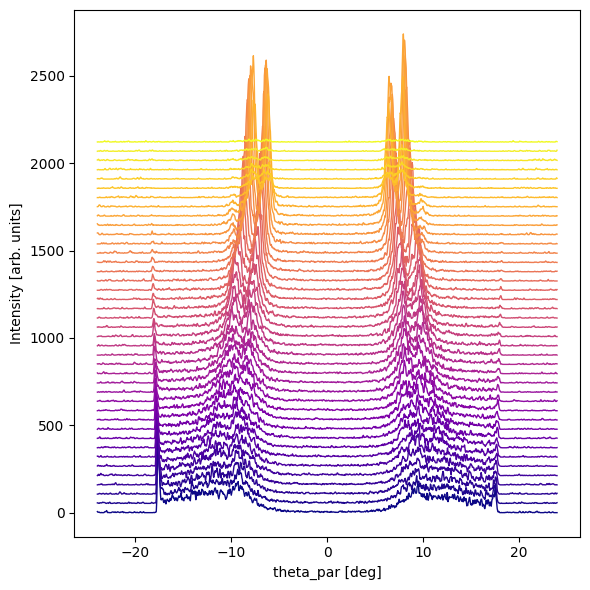

In [49]:
a.MDCs(104.9, 105.1, 0.005, plot=True, cmap='plasma')

The equivalent functions exist for EDCs (`.EDC` and `.EDCs`):


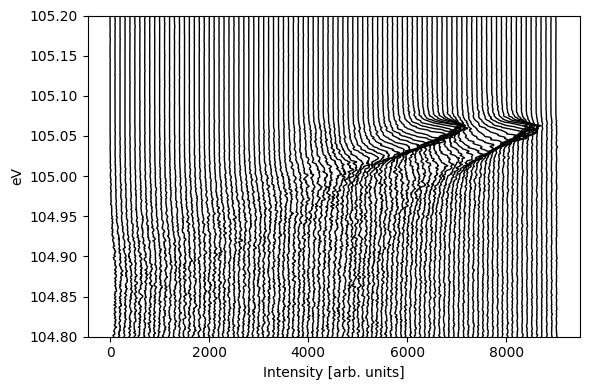

In [50]:
a.EDCs(-14, -5, 0.1, 0.05, plot=True, offset=100, ylim=[104.8,105.2], figsize=(6,4))

A general function for DC extraction along any arbitrary axis can also be called from `DC`:

In [51]:
help(DC)

Help on function DC in module peaks.core.display.DC_select:

DC(dispersion, DC_sel, DC_vals, DC_delta, plot, **kwargs)
    Master DC extraction function
    
    Parameters
    ------------
    dispersion : xr.DataArray
         The dispersion (2D dataarray) to extract DCs from
    
    DC_sel : str
        co-ordinate to select along
    
    DC_vals : list
        array of DC values to select
    
    DC_delta : float
        Integration range (total range, integrates +/- DC_delta/2) <br>
    
    plot : bool
         Flag indicating whether to return a plot
    
    **kwargs : optional
        Additional arguments to pass to the plotting function <br>
        See peaks.display.DC_extract.plot_DCs.
    
    Returns
    ------------
    DC : xr.DataArray
        xarray DataArray of DC stack or plot if called with `plot=True`



#### DOS extraction
`DOS` is a shortcut function to integrate along all dimensions of the data except for the energy, to approximate the density of states. For 2D data, this returns a result equivalent to using the EDC function with an integration range of the full dimension, but it works also for higher-dimensional data.

In [52]:
help(DOS)

Help on function DOS in module peaks.core.display.DC_select:

DOS(data)
    Integrate over all but the energy axis to return the best approximation to the DOS possible from the data
    
    Parameters
    ------------
    data : xr.DataArray
         Data to extract DOS from
    
    Returns
    ------------
    DOS : xr.DataArray
        xarray DataArray of DOS



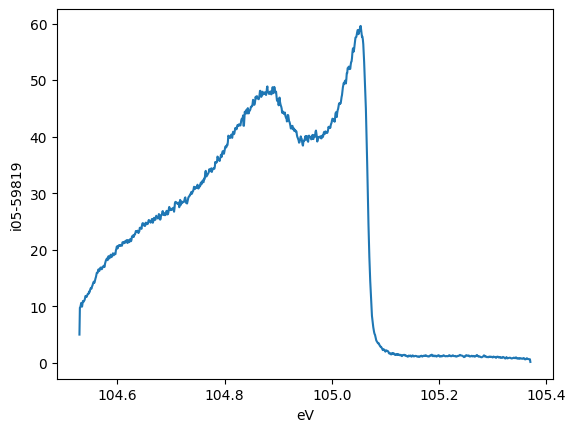

In [53]:
a.DOS().plot()

### Fermi surface extraction
As an extension of a generalised MDC extraction, a constant energy slice can be extracted using `.FS()`. This is almost identical to `.MDC()` except that the default energy is E0=0.

In [54]:
help(FS)

Help on function FS in module peaks.core.display.DC_select:

FS(cube, E0=0, dE=0)
    Extract a constant energy slice (e.g. a Fermi surface) from a 3D dataarray. <br>
    Thin wrapper around peaks.display.DC_select.MDC
    
    Parameters
    ------------
    cube : xr.DataArray
         The 3D data cube to extract FS from
    
    E0 : float
        Energy of slice to extract
    
    dE : float, optional
        Integration range (total range, integrates +/- dE/2) <br>
        Defaults to single slice
    
    Returns
    ------------
    FS : xr.DataArray
        xarray DataArray of constant energy slice



In [55]:
a = load(59818)

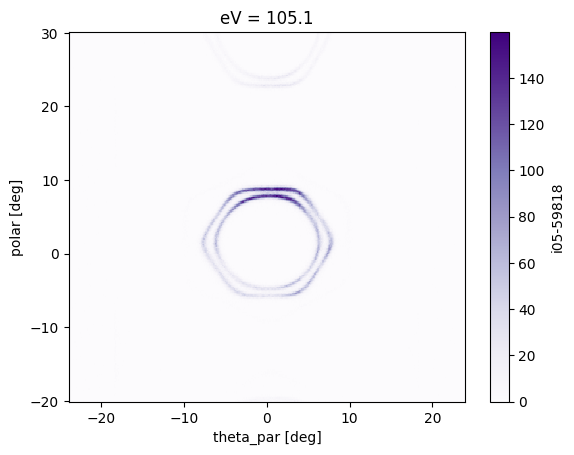

In [56]:
a.FS(105.067, 0.01).plot()

A stack of constant energy contours can be returned and optionally plotted using `.FS_stack`

In [57]:
help(FS_stack)

Help on function FS_stack in module peaks.core.display.DC_select:

FS_stack(cube, E0, E1, Estep, dE=0, plot=False, cmap='Purples', vmax=None, figsize=(8, 12), elev=10.0, azim=-60.0, **kwargs)
    Extract a set of constant energy slices from a 3D dataarray. <br>
    Optionally returns a stack plot.
    
    Parameters
    ------------
    cube : xr.DataArray
         The 3D data cube to extract FS from
    
    E0 : float
        Energy of fist slice to extract
    
    E1 : float
        Energy of last slice to extract
    
    Estep : float
        Energy step between slices
    
    dE : float, optional
        Integration range (total range, integrates +/- dE/2) <br>
        Defaults to single slice
    
    plot : bool, optional
        Call with 'plot=True' to return a plot
    
    cmap : str, optional
        colourmap to use, default Purples
    
    vmax : float, optional
        colour scale maximum, defaults to full range
    
    figsize : tuple, optional
        spec figur

In [58]:
# Get the data back
aFS = a.sel(theta_par=slice(-15,15),polar=slice(-15,15)).FS_stack(105.067-0.3,105.067,0.025, 0.02, plot=False)

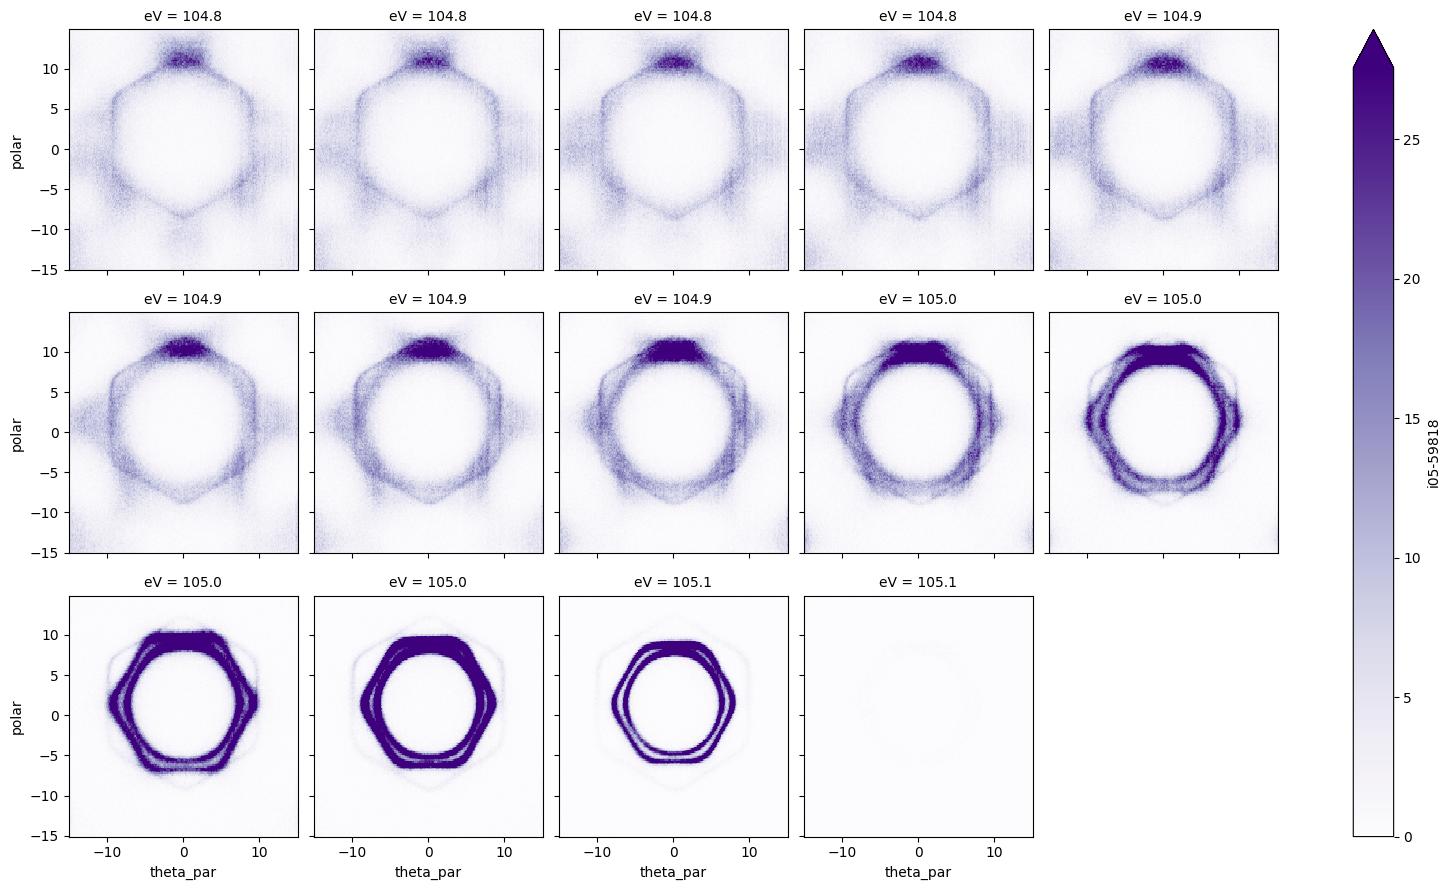

In [59]:
# Plot using standard xarray calls
aFS.plot(col='eV', col_wrap=5, robust=True)

A fancy stack plot can be returned directly (NB this is slow). To adjust aspect ratio and perspective, play with figure size and camera angles; to change x/y axis limits, it is better to do that on the data you are passing, as the 3d plot of matplotlib doesn't crop if you limit the axis ranges.


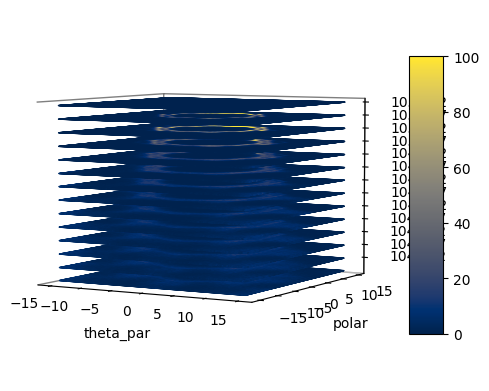

CPU times: user 38.7 s, sys: 3.95 s, total: 42.7 s
Wall time: 28.9 s


In [64]:
%%time
a.sel(theta_par=slice(-15, 15), polar=slice(-15, 15)).FS_stack(105.067-0.3, 105.067, 0.025, 0.02, plot=True, vmax=100,
                                                               cmap='cividis', figsize=(6, 18), elev=5)

### Radial cuts
A set of radial cuts around the Fermi surface can be extracted using `.radial_cuts`

In [61]:
help(radial_cuts)

Help on function radial_cuts in module peaks.core.display.DC_select:

radial_cuts(xarray, num_azi=60, num_points=100, radius=2, **kwargs)
    Function to extract radial cuts of Fermi surfaces, and plot them against azimuth
    
    Inputs:
        xarray - the data from which radial cuts will be extracted (xarray)
        **kwargs:
            num_azi - the number of evenly spaced azi values between 0 and 360 degrees to take radial cuts (integer)
            num_points - the number of evenly spaced points to sample along a cut (integer)
            radius - the maximum radius to take cuts up to (float)
            x - the coordinate to take as centre for x (float)
                e.g. k_par = 1 sets the k_par centre as 1
            y - the coordinate to take as centre for y (float)
                e.g. polar = 0.5 sets the polar centre as 0.5
    
    Returns:
        xarray_to_return - radial cuts against azi (xarray)



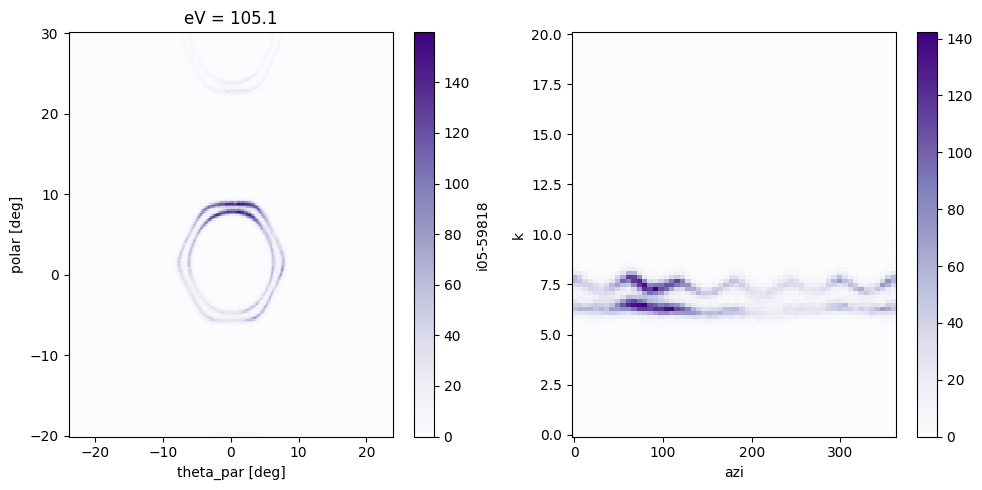

In [62]:
aFS = a.FS(105.067, 0.01)
arad = aFS.radial_cuts(radius=20, polar=1.5)
plot_grid([aFS,arad])